In [1]:
# Dana Rozenblum & Efrat Magidov

# Checklist:
# AWS emr-5.29.0
# MASTER r5d.2xlarge 1x, no EBS
# CORE r5d.2xlarge 2x, no EBS
# Custom bootstrap action: s3://ydatazian/bootstrap.sh
# Allow ssh in master node security group

In [2]:
import tqdm.notebook as tqdm
import numpy as np
import scipy
import sklearn

# Spark

In [3]:
# connect, context, session

import findspark
findspark.init()

import spark_utils
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
sc = SparkContext("yarn", "My App", conf=spark_utils.get_spark_conf())

spark_utils.print_ui_links()

NameNode: http://ec2-54-147-70-207.compute-1.amazonaws.com:50070
YARN: http://ec2-54-147-70-207.compute-1.amazonaws.com:8088
Spark UI: http://ec2-54-147-70-207.compute-1.amazonaws.com:20888/proxy/application_1622911840622_0006


In [4]:
se = SparkSession(sc)

## Outbrain click prediction dataseet

https://www.kaggle.com/c/outbrain-click-prediction/data

### AWS S3

In [5]:
! aws s3 ls s3://ydatazian

                           PRE week1/
2021-05-21 04:09:44       1874 bootstrap.sh
2021-05-13 21:20:22  176843889 clicks_test.parquet
2021-05-13 21:20:22  495815517 clicks_train.parquet
2021-05-13 21:21:58   34267065 documents_categories.parquet
2021-05-13 21:21:58  206455957 documents_entities.parquet
2021-05-13 21:21:58   23859965 documents_meta.parquet
2021-05-13 21:21:58  187410196 documents_topics.parquet
2021-05-13 21:21:58  734643471 events.parquet
2021-05-13 21:56:44 50764611872 page_views.parquet
2021-05-13 21:21:58  248421413 page_views_sample.parquet
2021-05-13 21:21:59    5116927 promoted_content.parquet
2021-05-13 21:21:58  273136709 sample_submission.csv


In [6]:
from IPython.display import display
tables = ["clicks_test",
          "clicks_train", 
          "documents_categories",
          "documents_entities",
          "documents_meta",
          "documents_topics", 
          "events",
          "page_views",
          "page_views_sample",
          "promoted_content"]
for name in tqdm.tqdm(tables):
    df = se.read.parquet("s3://ydatazian/{}.parquet".format(name))
    df.registerTempTable(name)
    print(name)
    df.limit(3).show()

  0%|          | 0/10 [00:00<?, ?it/s]

clicks_test
+----------+------+
|display_id| ad_id|
+----------+------+
|  16874594| 66758|
|  16874594|150083|
|  16874594|162754|
+----------+------+

clicks_train
+----------+------+-------+
|display_id| ad_id|clicked|
+----------+------+-------+
|         1| 42337|      0|
|         1|139684|      0|
|         1|144739|      1|
+----------+------+-------+

documents_categories
+-----------+-----------+----------------+
|document_id|category_id|confidence_level|
+-----------+-----------+----------------+
|    1595802|       1611|            0.92|
|    1595802|       1610|            0.07|
|    1524246|       1807|            0.92|
+-----------+-----------+----------------+

documents_entities
+-----------+--------------------+-----------------+
|document_id|           entity_id| confidence_level|
+-----------+--------------------+-----------------+
|    1524246|f9eec25663db4cd83...|0.672865314504701|
|    1524246|55ebcfbdaff1d6f60...|0.399113728441297|
|    1524246|839907a972930b17b

In [7]:
page_views = se.table("page_views")
print(page_views)
page_views.show(5)

DataFrame[uuid: string, document_id: string, timestamp: string, platform: string, geo_location: string, traffic_source: string]
+--------------+-----------+---------+--------+------------+--------------+
|          uuid|document_id|timestamp|platform|geo_location|traffic_source|
+--------------+-----------+---------+--------+------------+--------------+
|1fd5f051fba643|        120| 31905835|       1|          RS|             2|
|8557aa9004be3b|        120| 32053104|       1|       VN>44|             2|
|c351b277a358f0|        120| 54013023|       1|       KR>12|             1|
|8205775c5387f9|        120| 44196592|       1|       IN>16|             2|
|9cb0ccd8458371|        120| 65817371|       1|   US>CA>807|             2|
+--------------+-----------+---------+--------+------------+--------------+
only showing top 5 rows



## HW 2 [Optional] Spark SQL

Dataset: outbrain click prediction
Get complex queries over Outbrain dataset:

1 (1 point) *. Find out the average uuid (user) CTR (number of clicks in all of her display_ids / (number of impressions ... + 10)). Plot the distribution of individual CTRs as a histogram (bins=100).

2 (1 point) *. Find out how many page views has an average user before encountering a display_id (use timestamp columns). Plot the distribution of individual values.

array([[<AxesSubplot:title={'center':'CTR'}>]], dtype=object)

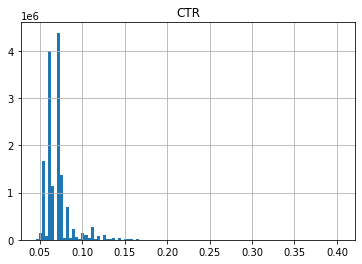

In [8]:
# 1 (1 point) *. Find out the average uuid (user) 
# CTR (number of clicks in all of her display_ids / (number of impressions ... + 10)). 
# Plot the distribution of individual CTRs as a histogram (bins=100).

import pandas as pd

events = se.table("events")
clicks_train = se.table("clicks_train")

avg_user_ctr = se.sql("""
    SELECT e.uuid, SUM(ct.clicked) / (COUNT(ct.clicked) + 10) CTR
    FROM clicks_train ct
    JOIN events e ON ct.display_id = e.display_id
    GROUP BY e.uuid
""").toPandas()

avg_user_ctr.set_index('uuid')
avg_user_ctr.hist(bins=100)

In [9]:
# 2 (1 point) *. Find out how many page views has an average user before encountering a display_id (use timestamp columns). 
# Plot the distribution of individual values.

# (Had to split to steps due to memory issues)

before_views = se.sql("""
    WITH fd AS (
        SELECT uuid, MIN(timestamp) min_time
        FROM events
        GROUP BY uuid
    )
    SELECT pv.uuid, pv.timestamp, fd.min_time
    FROM page_views pv
    LEFT JOIN fd ON pv.uuid = fd.uuid
""")

In [10]:
from pyspark.sql.functions import col

before_views = before_views.where(col("min_time").isNull() | (col("timestamp") < col("min_time")))

In [15]:
grouped = (
    before_views
      .groupby('uuid')
      .count().withColumnRenamed("count","num_views")
      .select(['uuid', 'num_views'])
)

In [16]:
grouped = (
    grouped
      .groupby('num_views')
      .count()
      .select(['num_views', 'count'])
)

In [17]:
grouped = grouped.toPandas()
grouped = grouped.set_index('num_views')

In [49]:
import matplotlib.pyplot as plt

full = pd.DataFrame({'num_views':range(0,900)})
full = full.set_index('num_views')

In [52]:
data = pd.merge(full, grouped, how="outer", left_index=True, right_index=True)
data.fillna(0, inplace=True)

([<matplotlib.axis.XTick at 0x7f2bfab46080>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8')])

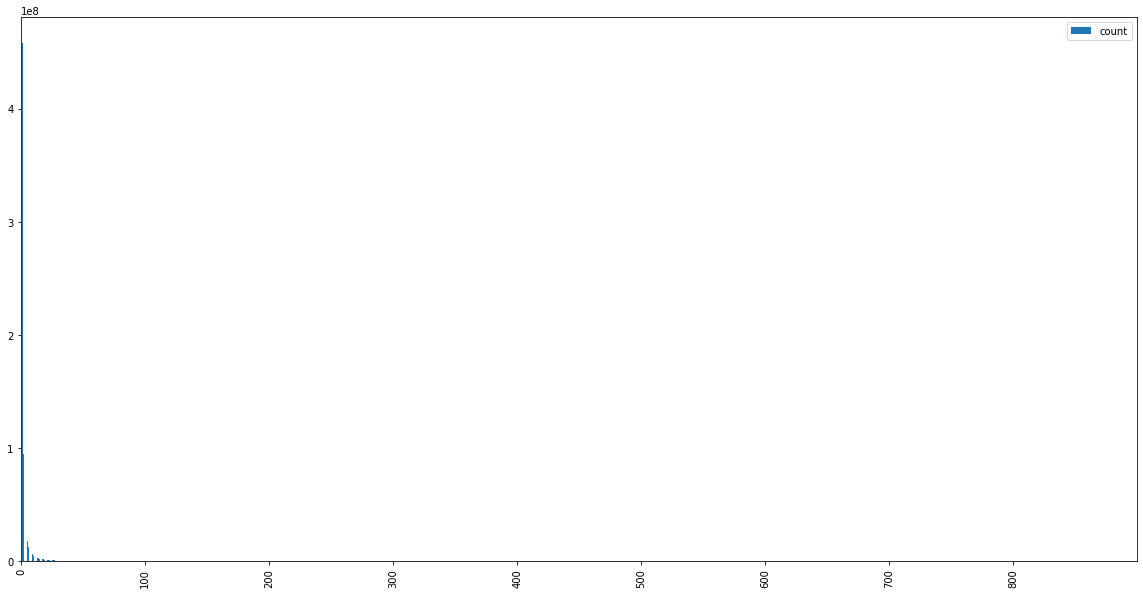

In [58]:
data.sort_index().plot(kind='bar',y='count',figsize=(20,10))
plt.xticks(range(0,900, 100))